In [11]:
import librosa
from peak_extractor import Analyzer, peaks2mask
from util import load_config
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

Max value in sgram: 0.2668965756893158
0.008058547973632812
380


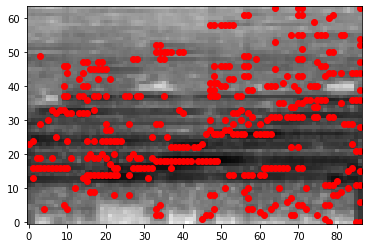

In [37]:
cfg = load_config('config/audfp.yaml')

filename = librosa.example('nutcracker')
analyzer = Analyzer(cfg=cfg, density=250.0)
d, sr = librosa.load(filename, sr=cfg['fs'])
t = np.random.randint(0, len(d)/sr - 0.96 - 1)
# t = 26
d = d[sr*t : int(sr*(t+ 1.0))]
# peaks, pklist = analyzer.wavfile2peaks(filename)
mywin = np.hanning(cfg['n_fft'] + 2)[1:-1]
S = np.abs(librosa.stft(y=d, n_fft=cfg['n_fft'],
                        hop_length=cfg['hop_len'],
                        window=mywin))
# S = np.abs(librosa.stft(y=d, n_fft=512,
#                         hop_length=256,
#                         window='hanning'))
sgram = librosa.feature.melspectrogram(S=S, n_mels=64)
print(f"Max value in sgram: {np.max(sgram)}")

t1 = time.time()
peaks, pklist = analyzer.find_peaks(sgram=sgram, backward=False)
t2 = time.time()
print(t2-t1)
print(len(pklist))
# plt.figure(figsize=(20,5))
pklist[:,0] = pklist[:,0] * sgram.shape[1]
pklist[:,1] = pklist[:,1] * sgram.shape[0]
plt.scatter(np.array(pklist)[:,0], np.array(pklist)[:,1], color='red',alpha=1.0, marker='o')
S_dB = librosa.power_to_db(sgram, ref=np.max)
plt.imshow(S_dB, cmap='gray_r', interpolation='nearest', aspect='auto', origin='lower', alpha=1)
plt.show()

In [3]:
pklist = torch.tensor(pklist)
# Pad pklist to have 256 points
print(pklist.shape)
pklist = torch.cat((pklist, torch.zeros(256 - pklist.shape[0], 3)))
pklist.shape

torch.Size([219, 3])


torch.Size([256, 3])

In [7]:
pklist[:,0] = pklist[:,0] * sgram.shape[1]
pklist

tensor([[0.0000e+00, 1.8750e-01, 3.2362e-01],
        [0.0000e+00, 2.8125e-01, 4.9201e-01],
        [0.0000e+00, 3.1250e-01, 5.3046e-01],
        [0.0000e+00, 3.7500e-01, 7.3528e-02],
        [0.0000e+00, 5.4688e-01, 8.9176e-02],
        [1.0000e+00, 4.6875e-02, 1.1708e-01],
        [1.0000e+00, 9.3750e-02, 5.6081e-02],
        [1.0000e+00, 2.9688e-01, 7.6072e-01],
        [1.0000e+00, 3.5938e-01, 1.5856e-01],
        [1.0000e+00, 5.0000e-01, 4.7775e-01],
        [1.0000e+00, 7.0312e-01, 5.2320e-02],
        [1.0000e+00, 8.2812e-01, 8.8477e-02],
        [2.0000e+00, 3.5938e-01, 2.2001e-01],
        [2.0000e+00, 6.7188e-01, 5.0167e-02],
        [3.0000e+00, 4.6875e-01, 9.9060e-02],
        [3.0000e+00, 7.1875e-01, 6.1555e-02],
        [3.0000e+00, 8.2812e-01, 8.5457e-02],
        [4.0000e+00, 4.6875e-02, 1.0564e-01],
        [4.0000e+00, 1.7188e-01, 3.1309e-01],
        [4.0000e+00, 3.4375e-01, 3.3588e-01],
        [4.0000e+00, 7.0312e-01, 5.3082e-02],
        [5.0000e+00, 4.6875e-02, 1

In [5]:
a = torch.rand(219, 3)
b = torch.rand(230, 3)
c = torch.rand(223, 3)
p_list = [a, b, c]
max_p = max(arr.shape[0] for arr in p_list)
for i in range(len(p_list)):
    p_list[i] = torch.cat((p_list[i], torch.zeros(max_p - p_list[i].shape[0], 3)))

torch.stack(p_list).shape

torch.Size([3, 230, 3])

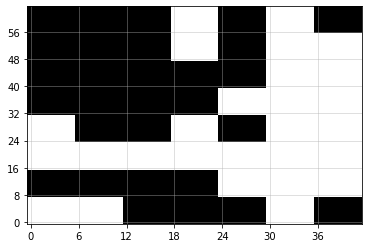

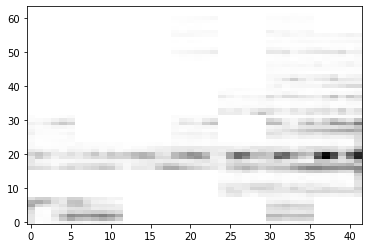

In [5]:
peaks_cut = peaks

mask = peaks2mask(peaks_cut)
fig = plt.figure()
ax = fig.add_subplot(111)
yticks = np.arange(0, 64, 8)
xticks = np.arange(0, 42, 6)
ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.grid(alpha=0.5)
plt.imshow(mask, cmap='gray', interpolation='nearest', aspect='auto', origin='lower')
plt.show()

plt.imshow(sgram*mask, cmap='gray_r', interpolation='nearest', aspect='auto', origin='lower')
plt.show()

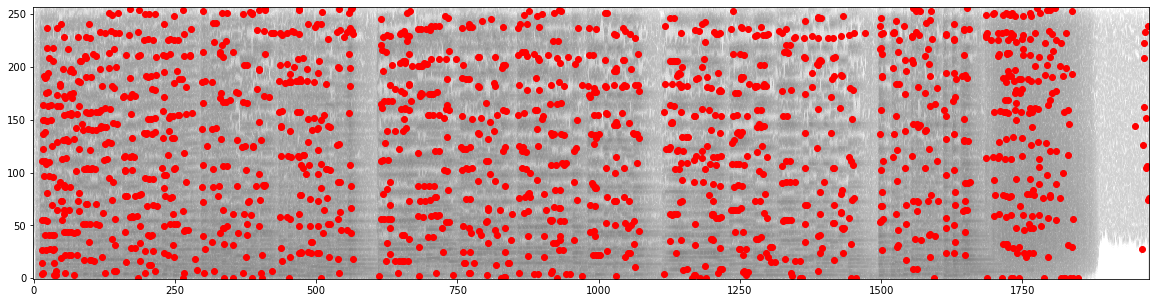

In [6]:
cfg = load_config('config/audfp.yaml')

filename = librosa.example('brahms')
analyzer = Analyzer(cfg=cfg, density=100.0)
d, sr = librosa.load(filename, sr=11025, duration=100.0)
# peaks, pklist = analyzer.wavfile2peaks(filename)
peaks, pklist = analyzer.find_peaks(d, sr)

plt.figure(figsize=(20,5))
plt.scatter(np.array(pklist)[:,0], np.array(pklist)[:,1], color='red',alpha=1.0, marker='o')
sgram = np.abs(librosa.stft(y=d, n_fft= 512,
                          hop_length=256,
                          window='hann'))
S_dB = librosa.power_to_db(sgram, ref=np.max)
plt.imshow(S_dB, cmap='gray_r', interpolation='nearest', aspect='auto', origin='lower', alpha=0.5)

plt.show()

In [ ]:
import torch.nn as nn
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
logmelspec = nn.Sequential(
    MelSpectrogram(sample_rate=cfg['fs'], 
                    win_length=cfg['win_len'], 
                    hop_length=cfg['hop_len'], 
                    n_fft=cfg['n_fft'], 
                    n_mels=cfg['n_mels']),
    AmplitudeToDB()
) 